In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model3 import *
import numpy as np
from datetime import datetime
import PPCA_MR3 as p
from linearmodels.asset_pricing import LinearFactorModel
import statsmodels.api as sm

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:36: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:38: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)

# Academic papers
Based on Illin, A., Raiko, T. 2010 paper called "Practical Approaches to Principal Component Analysis in the Presence of Missing Values"

Tipping and Bishop (1999) introducted probablistic formulation of PCA (PPCA)


Use a flavor of Probabilistic PCA that is robust to missing data (see Ilin and Raiko 2010). Rather than the vanilla one-shot SVD, PPCA uses an iterative EM procedure/fixed point algorithm. From an initial guess, it’ll alternatively interpolate missing data and update the components until convergence.

On a side note, PPCA interpolates using information from all series, making it a multivariate interpolator. Be careful though, fitting the model to too many components will likely lead to overfitting problems in the interpolated data.

Also note that I am using the standardization that is mentioned in Korajecyk and Sadka (2008) of expanding zscores


In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [106]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


In [21]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(labels=sector_zscores[sect].index,axis='index')
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print(sect)

In [107]:
sec='Equities'
ind=sector_PC[sec][0].index
mod=LinearFactorModel(sector_rtns[sec].loc[ind],sector_PC[sec][[0]])
res=mod.fit(cov_type='kernel')
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 28   R-squared:                      0.1047
No. Factors:                          1   J-statistic:                    427.92
No. Observations:                    53   P-value                         0.0000
Date:                  Sat, Mar 17 2018   Distribution:                 chi2(27)
Time:                          13:04:57                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
0              0.4365     0.4560     0.9574     0.3384     -0.4572      1.3302

Covariance estimator:
KernelCovaria

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


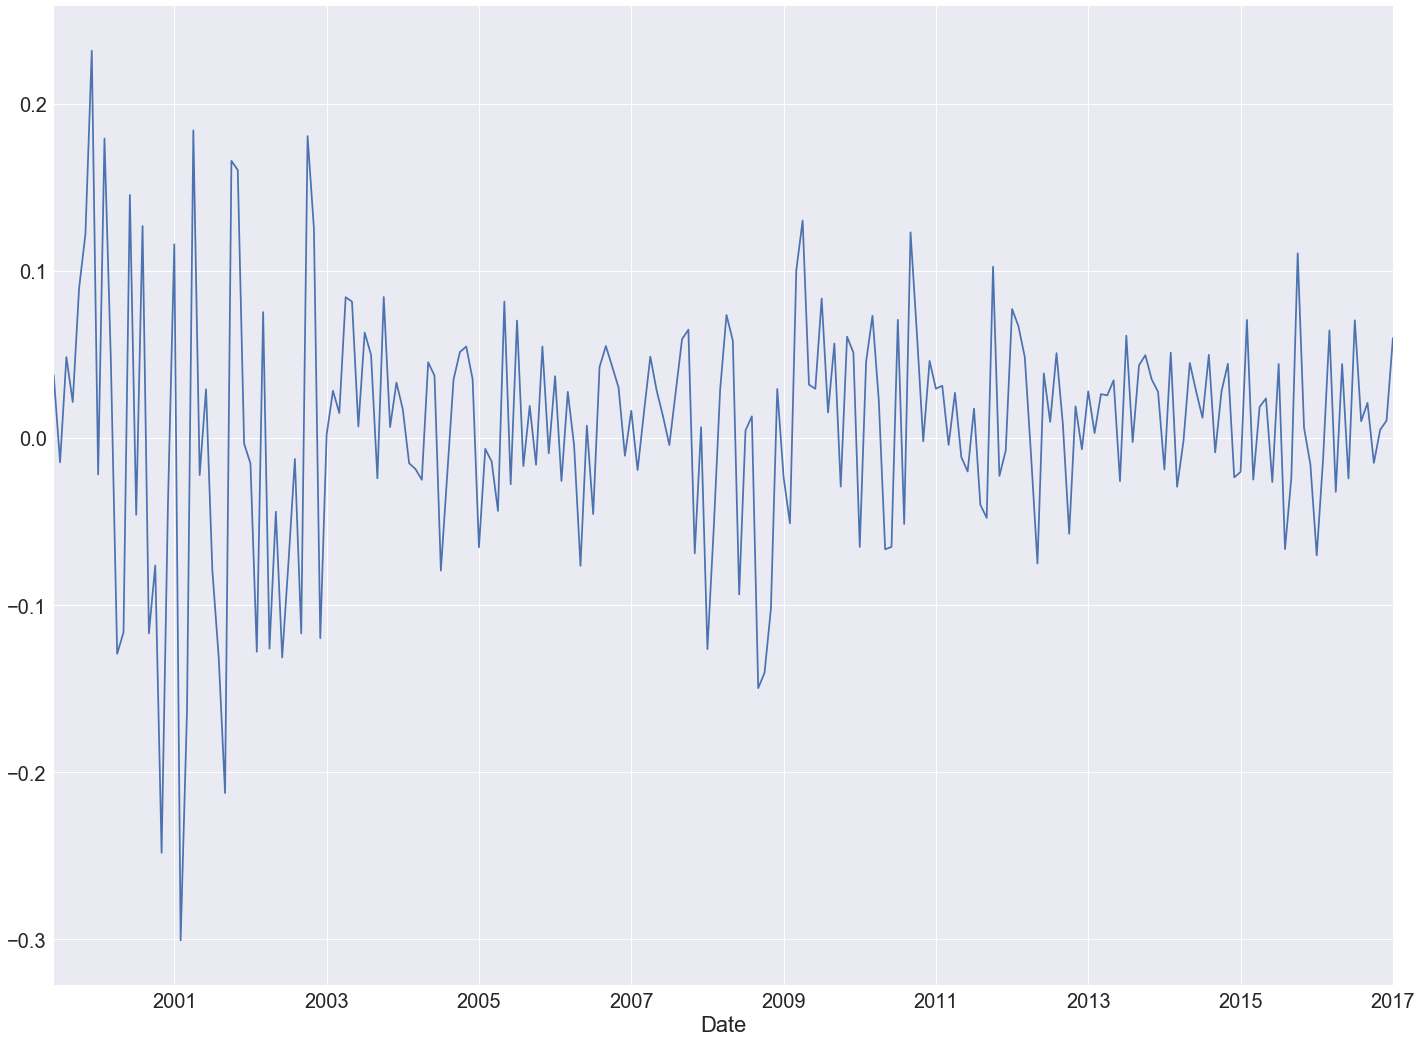

In [113]:
cleansed['Nasdaq'].dropna().pct_change().resample(rule='m',how='sum').plot()

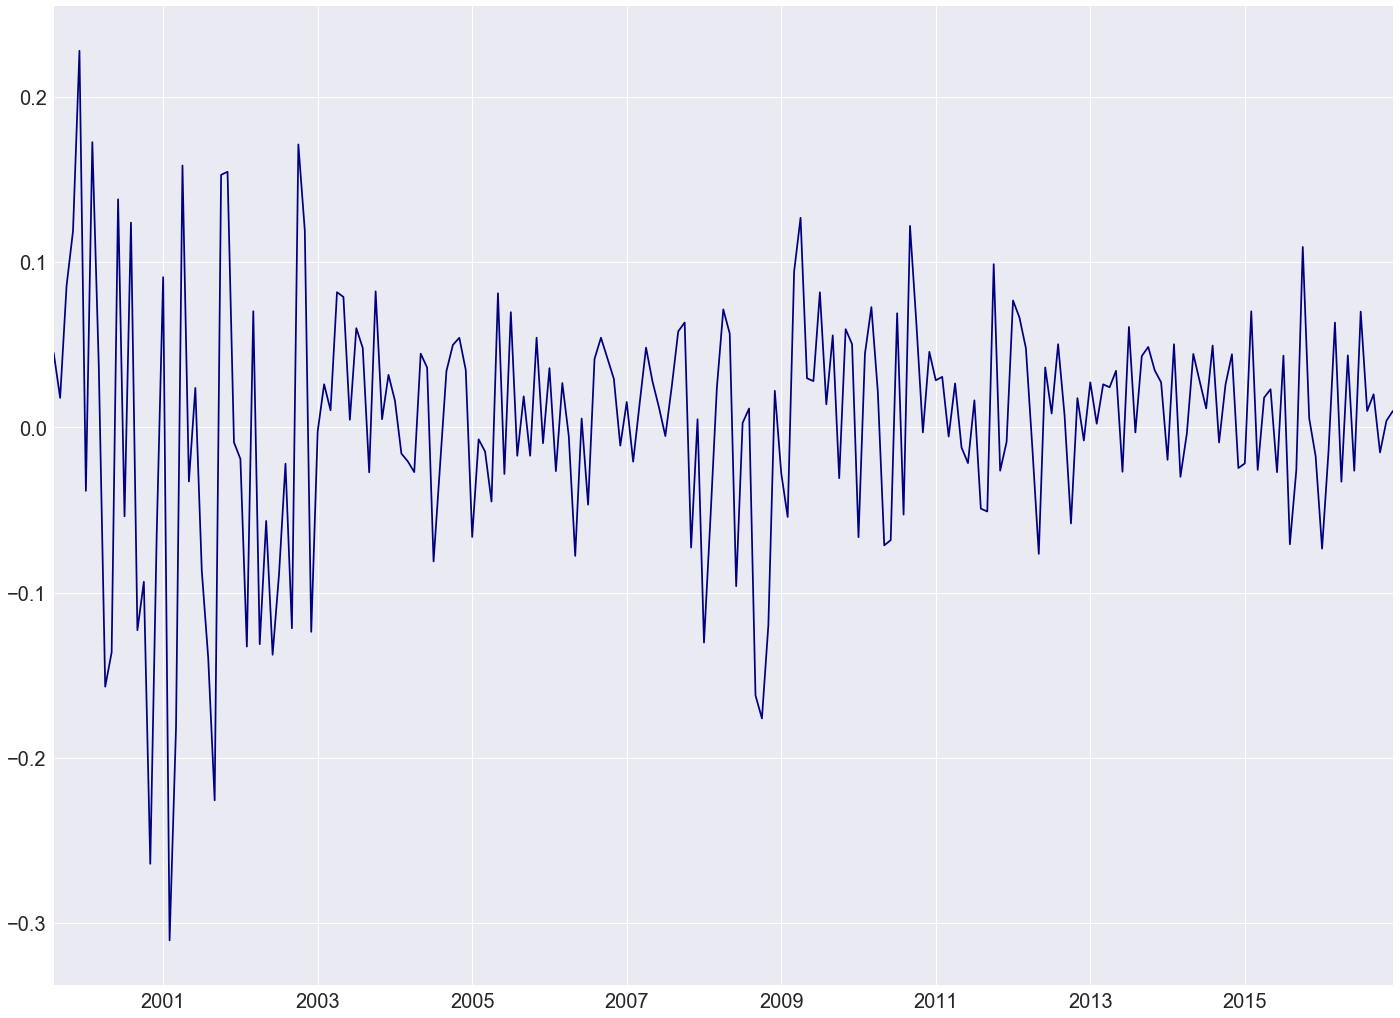

In [109]:
sector_rtns[sec].loc[ind]['Nasdaq'].plot(colormap='jet')

In [95]:
from linearmodels.asset_pricing import LinearFactorModelGMM
mod=LinearFactorModelGMM(sector_rtns[sec].loc[ind],sector_PC[sec][0])

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/utility.py:490: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [96]:
res = mod.fit(cov_type='kernel', kernel='bartlett', disp=0)
print(res)

                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                 28   R-squared:                  -3.287e+15
No. Factors:                          1   J-statistic:                -4.841e+28
No. Observations:                    53   P-value                         1.0000
Date:                  Sat, Mar 17 2018   Distribution:                 chi2(27)
Time:                          13:01:20                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor      1.524e+06                              nan                        

Covariance estimator:
KernelCovaria

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/linearmodels/asset_pricing/results.py:243: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(self._rp_cov))


In [97]:
res = mod.fit(steps=10, disp=25)
print(res)

Iteration: 0, Objective: -2.7861419212967964e+26
         Current function value: -278614192129679638363373568.000000
         Iterations: 1
         Function evaluations: 1548
         Gradient evaluations: 48
Iteration: 0, Objective: 1773566356819186.8
         Current function value: -9421424018869047296.000000
         Iterations: 7
         Function evaluations: 972
         Gradient evaluations: 30
Iteration: 0, Objective: 2.4008558778988687e+18
Optimization terminated successfully.
         Current function value: -76678491142448532941761402751743903491877425381376.000000
         Iterations: 4
         Function evaluations: 736
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 66444278294411144449946956918161408.000000
         Iterations: 0
         Function evaluations: 32
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: 66444278294411144449946956918161408.000000
    

In [98]:
print(res.full_summary)

                    LinearFactorModelGMM Estimation Summary                     
No. Test Portfolios:                 28   R-squared:                      -8e+21
No. Factors:                          1   J-statistic:                 6.644e+34
No. Observations:                    53   P-value                         0.0000
Date:                  Sat, Mar 17 2018   Distribution:                 chi2(27)
Time:                          13:01:22                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
factor     -1.351e+08     0.0689  -1.96e+09     0.0000  -1.351e+08  -1.351e+08


                          AEX-AEX 

# FHT method

In [128]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:270: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:271: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:272: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:272: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [129]:
sector_resid_FHT={}
sector_rsq_FHT={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_data={}
    rsq=pd.Series()
    for mkt in d_map[sect]:
        ind2=FHT[mkt].dropna().index
        ind=FHT[mkt].shift().loc[ind2].dropna().index
        res=sm.OLS(FHT[mkt].shift().loc[ind],FHT[mkt].loc[ind]).fit()
        sector_data[mkt]=res.resid
        rsq[mkt]=res.rsquared
    sector_resid_FHT[sect]=pd.DataFrame(sector_data)
    sector_rsq_FHT[sect]=rsq.mean()

Commodities     0.607543
Currencies      0.701559
Equities        0.726504
Fixed Income    0.515586
dtype: float64

# Presentation
First rsquares of residuals

In [144]:
results_rsq=pd.DataFrame()
results_rsq['Amihud']=pd.Series(sector_rsq)
results_rsq['FHT']=pd.Series(sector_rsq_FHT)
print results_rsq.round(2).to_latex()

\begin{tabular}{lrr}
\toprule
{} &  Amihud &   FHT \\
\midrule
Commodities  &    0.72 &  0.61 \\
Currencies   &    0.78 &  0.70 \\
Equities     &    0.75 &  0.73 \\
Fixed Income &    0.64 &  0.52 \\
\bottomrule
\end{tabular}

